# 爬取https://wp.m.163.com/163/page/news/virus_report/index.html?_nw_=1&_anw_=1

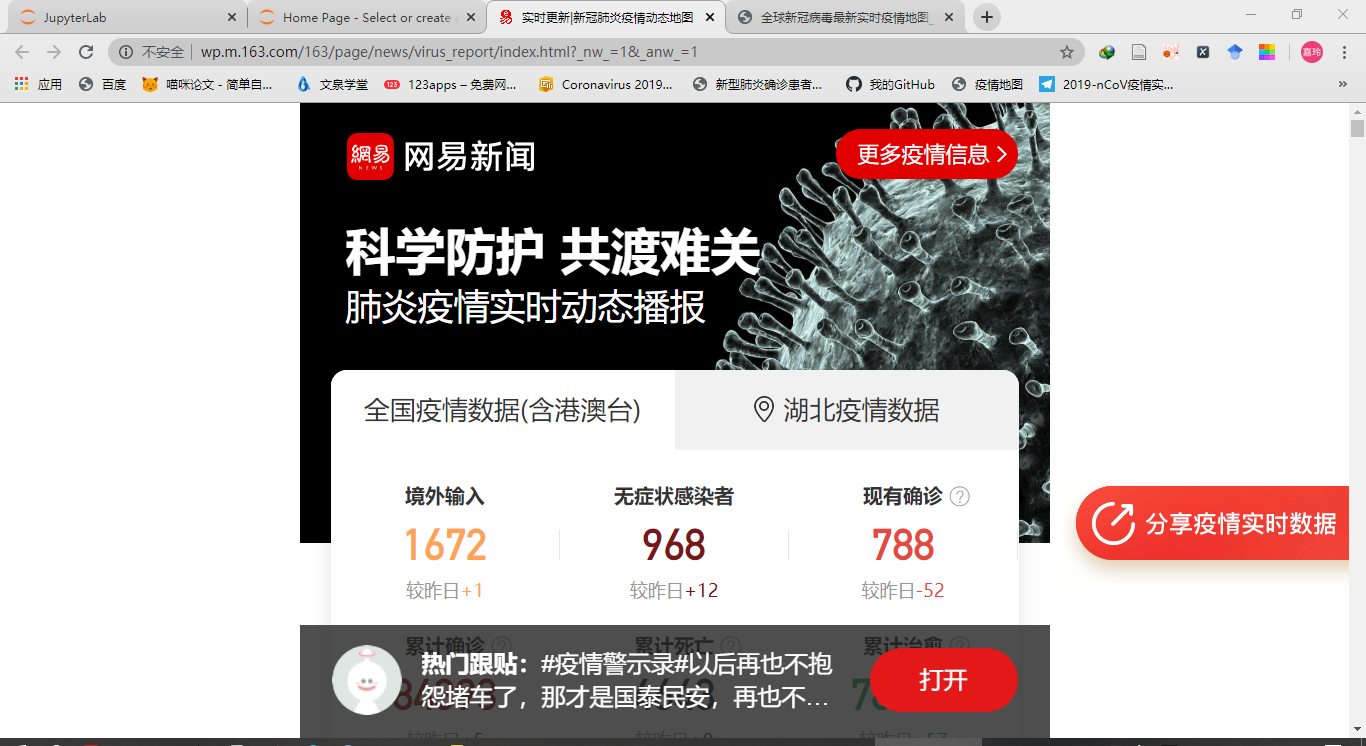

导入相关库并设置路径

In [1]:
import pandas as pd 
import requests
import json
import time
import re
import os
os.chdir("G:\\CDO\\数据存储和获取\\自定义爬虫作业")

右键----检查----network----ctrl+R-----数据的接口一般都在XHP-----preview

在header里面获取API

https://c.m.163.com/ug/api/wuhan/app/data/list-total?t=317679328722

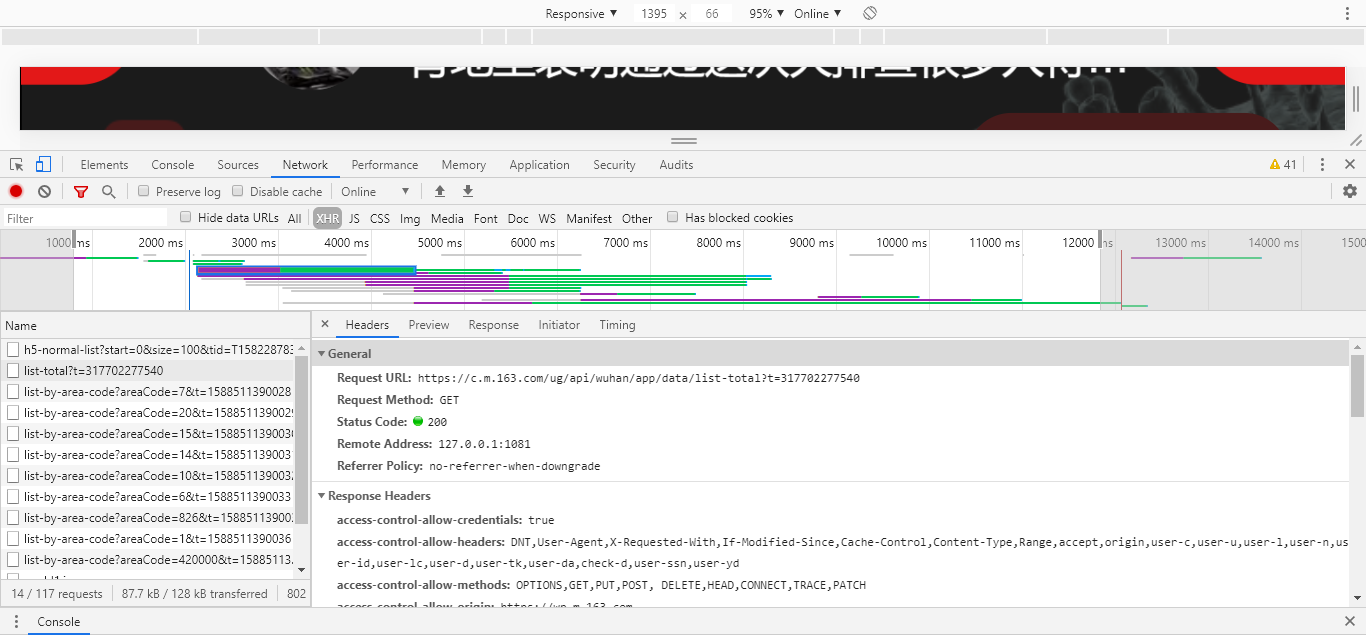

我们忽略时间戳，直接简洁为

https://c.m.163.com/ug/api/wuhan/app/data/list-total?

找代理user-agent:

Mozilla/5.0 (Linux; Android 6.0; Nexus 5 Build/MRA58N) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/81.0.4044.129 Mobile Safari/537.36

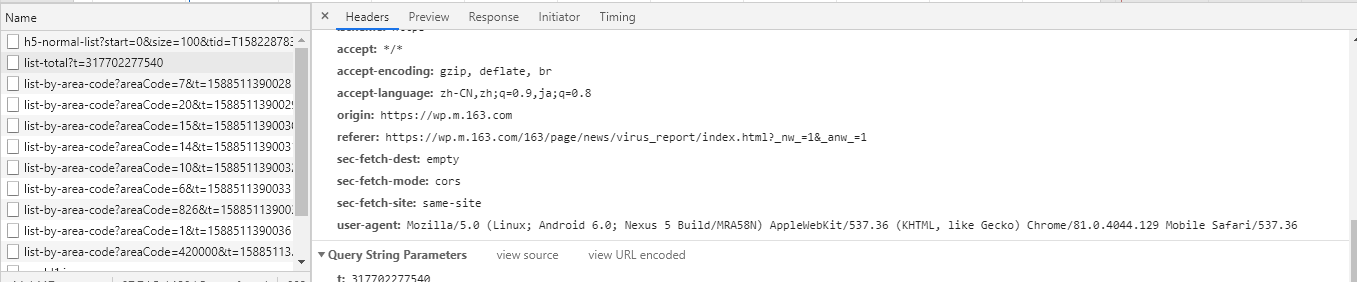

设置headers

In [2]:
headers={'user-agent':'Mozilla/5.0 (Linux; Android 6.0; Nexus 5 Build/MRA58N) AppleWebKit/537.36 \
         (KHTML, like Gecko) Chrome/81.0.4044.129 Mobile Safari/537.36'}

请求并获取网页源代码

In [6]:
url='https://c.m.163.com/ug/api/wuhan/app/data/list-total?'
res = requests.get(url,headers=headers)

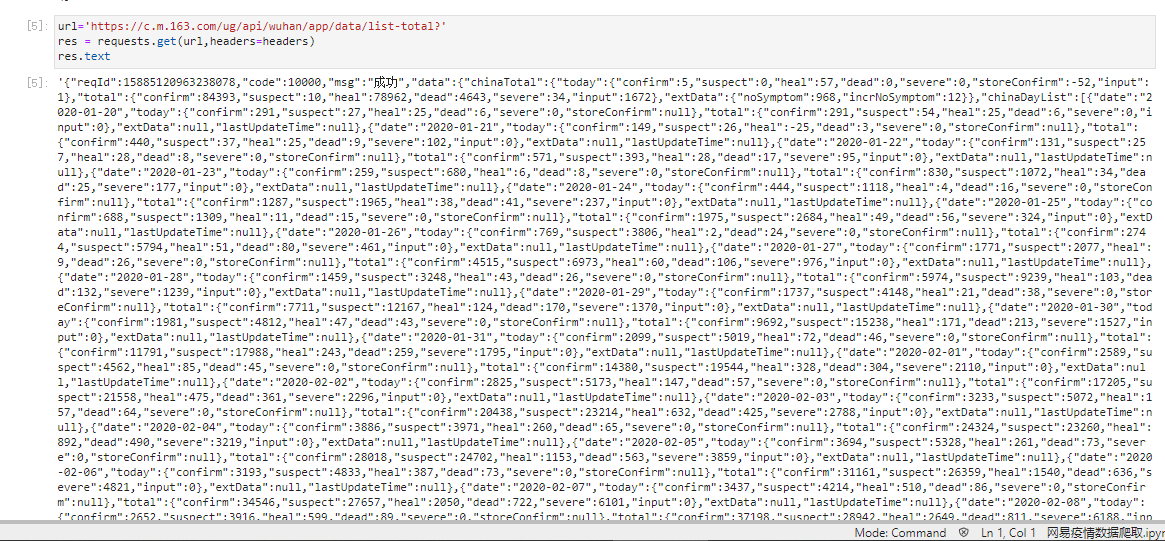

因为res.text打印出来太长了，无法使用head，所以我简单截图展示一下。

json格式查看和数据解析

In [7]:
print(type(res.text))
print(len(res.text))

<class 'str'>
256532


调用库的loads()方法将JSON文本字符串转为JSON对象，可以通过dumps()方法将JSON对象转为文本字符串。

这里使用loads()方法将字符串转为JSON对象。由于最外层是中括号，所以最终的类型是列表类型。


In [10]:
data=json.loads(res.text)

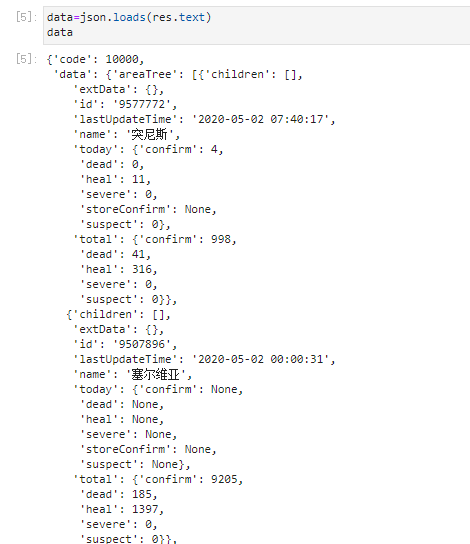

因为data打印出来太多了，无法使用head，所以简单截图展示一下

这样一来，我们就可以用索引来获取对应的内容了！

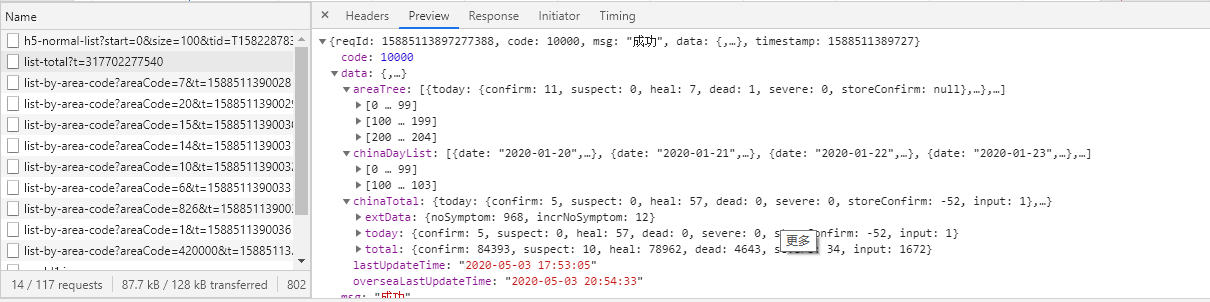

In [11]:
dat = data['data']
dat.keys()

dict_keys(['chinaTotal', 'chinaDayList', 'lastUpdateTime', 'overseaLastUpdateTime', 'areaTree'])

'chinaTotal':中国当日数据

'chinaDayList':中国历史数据

'lastUpdateTime': 最后更新的时间

'overseaLastUpdateTime':海外的最后更新的时间

'areaTree':世界各地实时数据


## 这里我们爬取中国历史数据

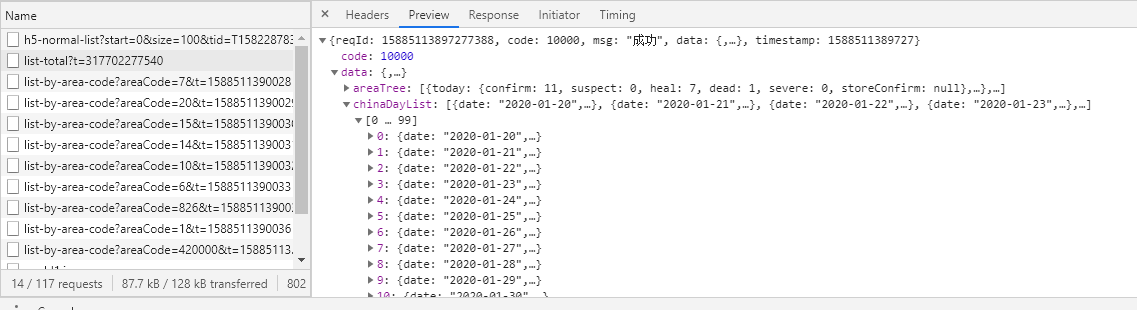

先索引出来

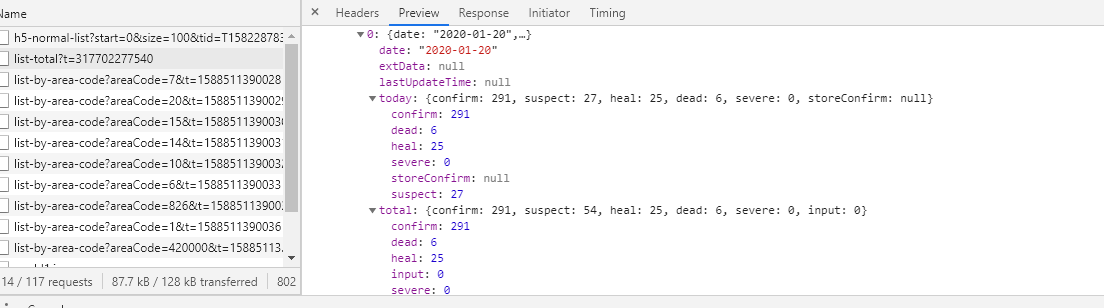

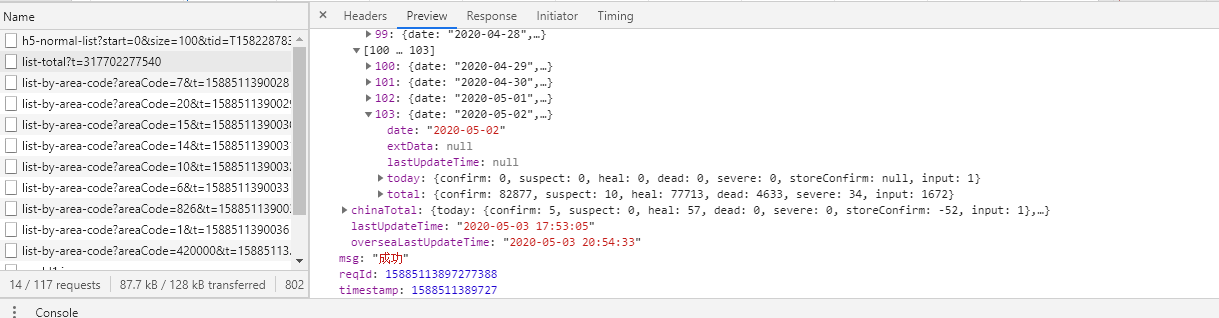

In [18]:
chinaDayList=dat['chinaDayList']
chinaDayList[0].keys()

dict_keys(['date', 'today', 'total', 'extData', 'lastUpdateTime'])

'date':日期

'today':当日数据

'total':累计数据

'lastUpdateTime':更新时间


##  建立数据框、修改部分列名并汇总数据

In [14]:
free_data=pd.DataFrame(chinaDayList)[['date','lastUpdateTime']]
today_data=pd.DataFrame([province['today'] for province in chinaDayList])
total_data=pd.DataFrame([province['total'] for province in chinaDayList])
today_data.columns=("today_"+ i for i in today_data.columns)
total_data.columns=("total" + i for i in total_data.columns)
chinaDayList_data=pd.concat([free_data,today_data,total_data],axis=1)
chinaDayList_data.head()

,date,lastUpdateTime,today_confirm,today_suspect,today_heal,today_dead,today_severe,today_storeConfirm,today_input,totalconfirm,totalsuspect,totalheal,totaldead,totalsevere,totalinput
0,2020-01-20,None,291,27,25,6,0,None,NaN,291,54,25,6,0,0
1,2020-01-21,None,149,26,-25,3,0,None,NaN,440,37,25,9,102,0
2,2020-01-22,None,131,257,28,8,0,None,NaN,571,393,28,17,95,0
3,2020-01-23,None,259,680,6,8,0,None,NaN,830,1072,34,25,177,0
4,2020-01-24,None,444,1118,4,16,0,None,NaN,1287,1965,38,41,237,0


In [15]:
name_dict={'date':'日期','lastUpdateTime':'更新时间','today_confirm':'当日新增确诊',
                        'today_dead':'当日新增死亡','today_heal':'当日新增治愈','today_input':'当日新增输入',
                        'today_severe':'当日新增重症', 'today_storeConfirm':'当日现存确诊',
                        'today_suspect':'当日新增疑似','totalconfirm':'累计确诊','totaldead':'累计死亡',
                        'totalheal':'累计治愈','totalinput':'累计输入',
                        'totalsevere':'累计重症','totalsuspect':'累计疑似'}

重命名列

In [17]:
chinaDayList_data.rename(columns=name_dict,inplace=True)
chinaDayList_data.head()

,日期,更新时间,当日新增确诊,当日新增疑似,当日新增治愈,当日新增死亡,当日新增重症,当日现存确诊,当日新增输入,累计确诊,累计疑似,累计治愈,累计死亡,累计重症,累计输入
0,2020-01-20,None,291,27,25,6,0,None,NaN,291,54,25,6,0,0
1,2020-01-21,None,149,26,-25,3,0,None,NaN,440,37,25,9,102,0
2,2020-01-22,None,131,257,28,8,0,None,NaN,571,393,28,17,95,0
3,2020-01-23,None,259,680,6,8,0,None,NaN,830,1072,34,25,177,0
4,2020-01-24,None,444,1118,4,16,0,None,NaN,1287,1965,38,41,237,0


## 数据存储

In [19]:
def save_data(data,name):
    file_name = name+'_'+time.strftime('%Y_%m_%d',time.localtime(time.time()))+'.xlsx'
    data.to_excel(file_name,index=None,encoding='utf-8')
    print(file_name+'保存成功！')
save_data(chinaDayList_data,'G:/CDO/数据存储和获取/自定义爬虫作业/chinaDayList_data')

G:/CDO/数据存储和获取/自定义爬虫作业/chinaDayList_data_2020_05_03.xlsx保存成功！


# 你以为到这里就结束了吗？

# 吼吼吼，还早呢，别浪费之前解析出来的那么多数据啊~

## 下面我们继续爬取全球实时疫情数据

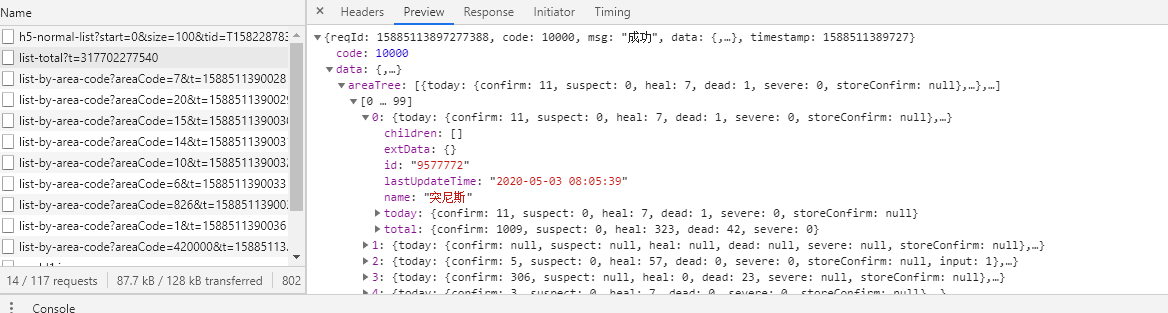

In [20]:
areaTree=dat['areaTree']
areaTree[0].keys()

dict_keys(['today', 'total', 'extData', 'name', 'id', 'lastUpdateTime', 'children'])

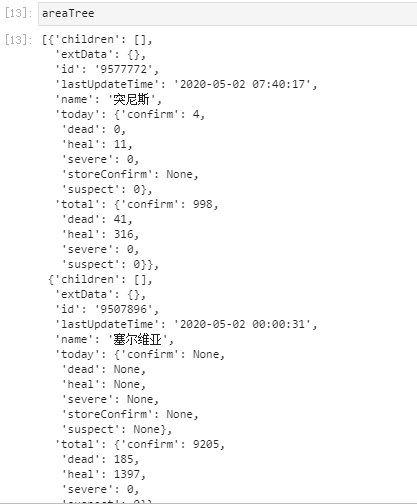

因为areaTree打印出来太多了，无法使用head，所以简单截图展示一下

In [21]:
free_data=pd.DataFrame(areaTree)[['id','lastUpdateTime','name']]
today_data=pd.DataFrame([province['today'] for province in areaTree])
total_data=pd.DataFrame([province['total'] for province in areaTree])
today_data.columns=("today_"+ i for i in today_data.columns)
total_data.columns=("total" + i for i in total_data.columns)
country_data=pd.concat([free_data,today_data,total_data],axis=1)
country_data.head()

,id,lastUpdateTime,name,today_confirm,today_suspect,today_heal,today_dead,today_severe,today_storeConfirm,today_input,totalconfirm,totalsuspect,totalheal,totaldead,totalsevere,totalinput
0,9577772,2020-05-03 08:05:39,突尼斯,11.0,0.0,7.0,1.0,0.0,None,NaN,1009,0,323,42,0,NaN
1,9507896,2020-05-03 00:00:31,塞尔维亚,NaN,NaN,NaN,NaN,NaN,None,NaN,9362,0,1426,189,0,NaN
2,0,2020-05-03 17:53:05,中国,5.0,0.0,57.0,0.0,0.0,None,1.0,84393,10,78962,4643,34,1672.0
3,1,2020-05-03 12:21:25,日本,306.0,NaN,0.0,23.0,NaN,None,NaN,15589,0,4632,517,0,NaN
4,2,2020-05-03 12:53:37,泰国,3.0,0.0,7.0,0.0,0.0,None,NaN,2969,0,2739,54,0,NaN


In [32]:
name_dict1={'date':'日期','name':'名称','id':'编号','lastUpdateTime':'更新时间',
            'today_confirm':'当日新增确诊',
           'today_dead':'当日新增死亡','today_heal':'当日新增治愈','today_input':'当日新增输入',
           'today_severe':'当日新增重症', 'today_storeConfirm':'当日现存确诊',
           'today_suspect':'当日新增疑似','totalconfirm':'累计确诊','totaldead':'累计死亡',
           'totalheal':'累计治愈','totalinput':'累计输入',
           'totalsevere':'累计重症','totalsuspect':'累计疑似'
          }

In [30]:
country_data.rename(columns=name_dict1,inplace=True)
country_data.head()

,编号,更新时间,名称,当日新增确诊,当日新增疑似,当日新增治愈,当日新增死亡,当日新增重症,当日现存确诊,当日新增输入,累计确诊,累计疑似,累计治愈,累计死亡,累计重症,累计输入,当日现存病例,死亡率
125,95787,2020-05-03 19:01:11,尼加拉瓜,1.0,0.0,0.0,0.0,0.0,None,NaN,14,0,7,3,0,NaN,4,0.214
167,95200,2020-05-03 04:54:38,也门,3.0,0.0,0.0,0.0,0.0,None,NaN,10,0,1,2,0,NaN,7,0.200
179,954332,2020-05-03 17:58:03,比利时,389.0,0.0,98.0,79.0,0.0,None,NaN,49906,0,12309,7844,0,NaN,29753,0.157
160,14,2020-05-03 20:40:06,英国,1240.0,NaN,0.0,74.0,NaN,None,NaN,183500,0,896,28205,0,NaN,154399,0.154
156,10,2020-05-03 10:02:30,法国,1050.0,0.0,350.0,166.0,0.0,None,NaN,168396,0,50562,24760,0,NaN,93074,0.147


## 计算当日现存病例和死亡率并将死亡率 强制转化为数值（方便计算）,查看死亡率前十的国家。

### 当日现存病例 = 累计确诊 - 累计治愈 - 累计死亡
### 死亡率 = 累计死亡 / 累计确诊

In [31]:
country_data['当日现存病例']=country_data['累计确诊']-country_data['累计治愈']-country_data['累计死亡']
country_data['死亡率']=((country_data['累计死亡']/country_data['累计确诊']).apply(lambda x : format(x,'.3f'))).astype('float')
country_data.sort_values('死亡率',ascending=False,inplace=True)
country_data.head(10)

,编号,更新时间,名称,当日新增确诊,当日新增疑似,当日新增治愈,当日新增死亡,当日新增重症,当日现存确诊,当日新增输入,累计确诊,累计疑似,累计治愈,累计死亡,累计重症,累计输入,当日现存病例,死亡率
125,95787,2020-05-03 19:01:11,尼加拉瓜,1.0,0.0,0.0,0.0,0.0,None,NaN,14,0,7,3,0,NaN,4,0.214
167,95200,2020-05-03 04:54:38,也门,3.0,0.0,0.0,0.0,0.0,None,NaN,10,0,1,2,0,NaN,7,0.200
179,954332,2020-05-03 17:58:03,比利时,389.0,0.0,98.0,79.0,0.0,None,NaN,49906,0,12309,7844,0,NaN,29753,0.157
160,14,2020-05-03 20:40:06,英国,1240.0,NaN,0.0,74.0,NaN,None,NaN,183500,0,896,28205,0,NaN,154399,0.154
156,10,2020-05-03 10:02:30,法国,1050.0,0.0,350.0,166.0,0.0,None,NaN,168396,0,50562,24760,0,NaN,93074,0.147
143,95287,2020-04-30 00:00:31,圣马丁岛,NaN,0.0,NaN,NaN,0.0,None,NaN,112,0,33,16,0,NaN,63,0.143
161,15,2020-05-03 01:37:40,意大利,1900.0,NaN,1665.0,474.0,NaN,None,NaN,209328,0,79914,28710,0,NaN,100704,0.137
56,95350,2020-05-03 18:54:00,巴哈马,2.0,0.0,1.0,0.0,0.0,None,NaN,82,0,24,11,0,NaN,47,0.134
70,95120,2020-05-03 20:54:33,荷兰,335.0,0.0,0.0,69.0,0.0,None,NaN,40571,0,322,5056,0,NaN,35193,0.125
80,8134,2020-05-01 00:00:31,毛里塔尼亚,NaN,0.0,NaN,NaN,0.0,None,NaN,8,0,6,1,0,NaN,1,0.125


In [27]:
def save_data(data,name):
    file_name = name+'_'+time.strftime('%Y_%m_%d',time.localtime(time.time()))+'.xlsx'
    data.to_excel(file_name,index=None,encoding='utf-8')
    print(file_name+'保存成功！')
save_data(country_data,'G:/CDO/数据存储和获取/自定义爬虫作业/country_data')

G:/CDO/数据存储和获取/自定义爬虫作业/country_data_2020_05_03.xlsx保存成功！





# 思考一个问题：为什么美国死亡率未进世界前十？

## 查看目前确诊排名前10的国家

In [33]:
world_top10 = country_data.sort_values(['累计确诊'],ascending = False).head(10)
world_top10 = world_top10[['名称','累计确诊','累计死亡','死亡率']]
world_top10.head(10)

,名称,累计确诊,累计死亡,死亡率
9,美国,1160838,67448,0.058
169,西班牙,245567,25264,0.103
161,意大利,209328,28710,0.137
160,英国,183500,28205,0.154
156,法国,168396,24760,0.147
8,德国,164967,6812,0.041
162,俄罗斯,134686,1280,0.010
144,土耳其,124375,3336,0.027
14,伊朗,97424,6203,0.064
71,巴西,96559,6750,0.070


# 现在中国疫情历史数据 和 全球实时数据都到手了，总觉得缺些什么？

# 哦 对 没有中国疫情实时数据，这个网站可以轻松解决，太没意思了

# 我们还是换个网站爬吧！

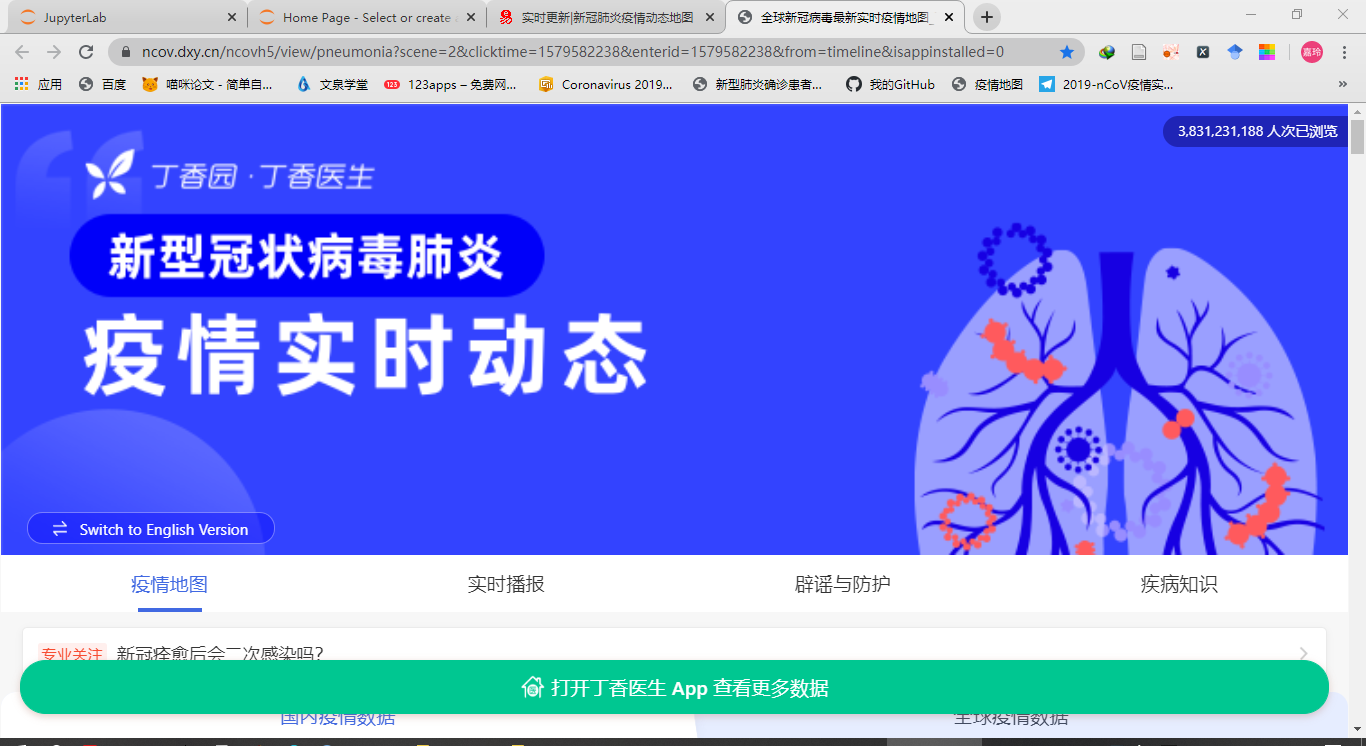

## 爬取丁香园疫情数据

https://ncov.dxy.cn/ncovh5/view/pneumonia?scene=2&clicktime=1579582238&enterid=1579582238&from=timeline&isappinstalled=0

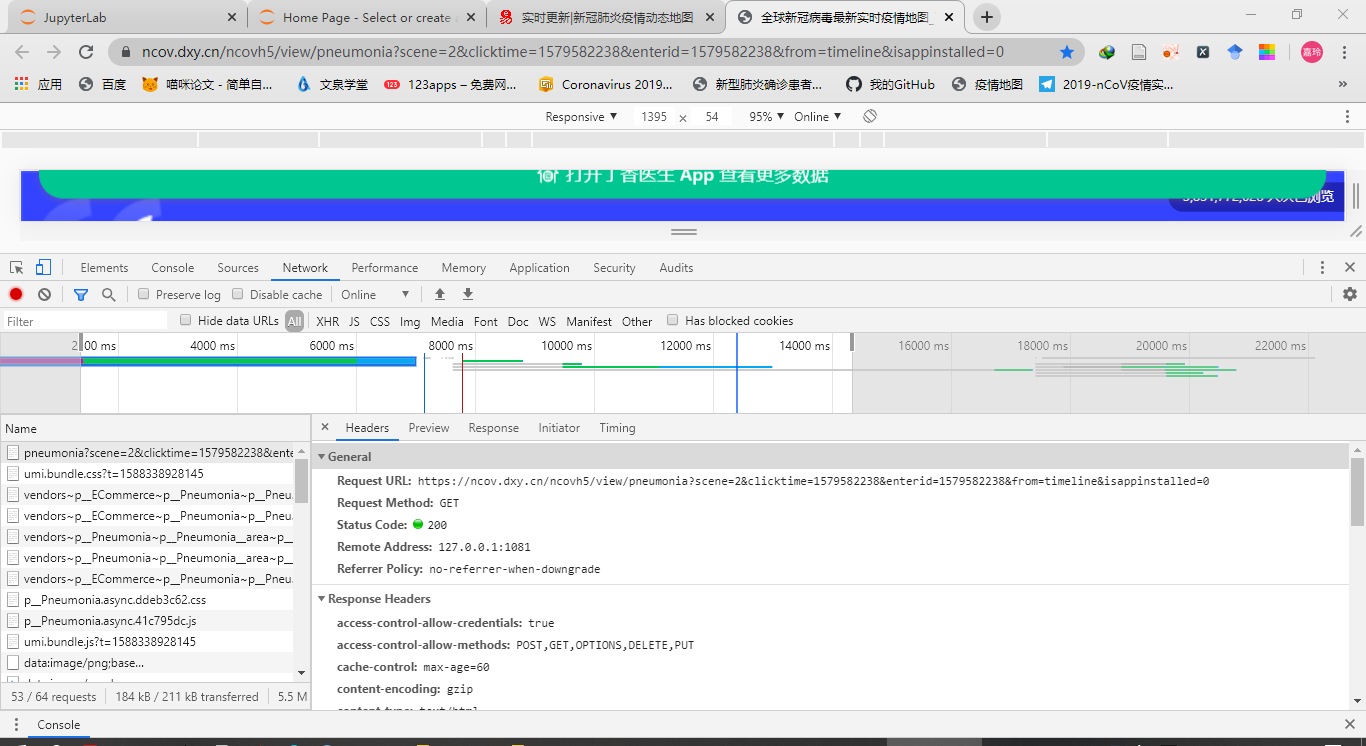

### 请求

In [35]:
url = 'https://3g.dxy.cn/newh5/view/pneumonia?scene=2&clicktime=1579582238&enterid=1579582238&from=timeline&isappinstalled=0'
reso = requests.get(url)
reso.encoding = 'utf - 8'

### 解析网页

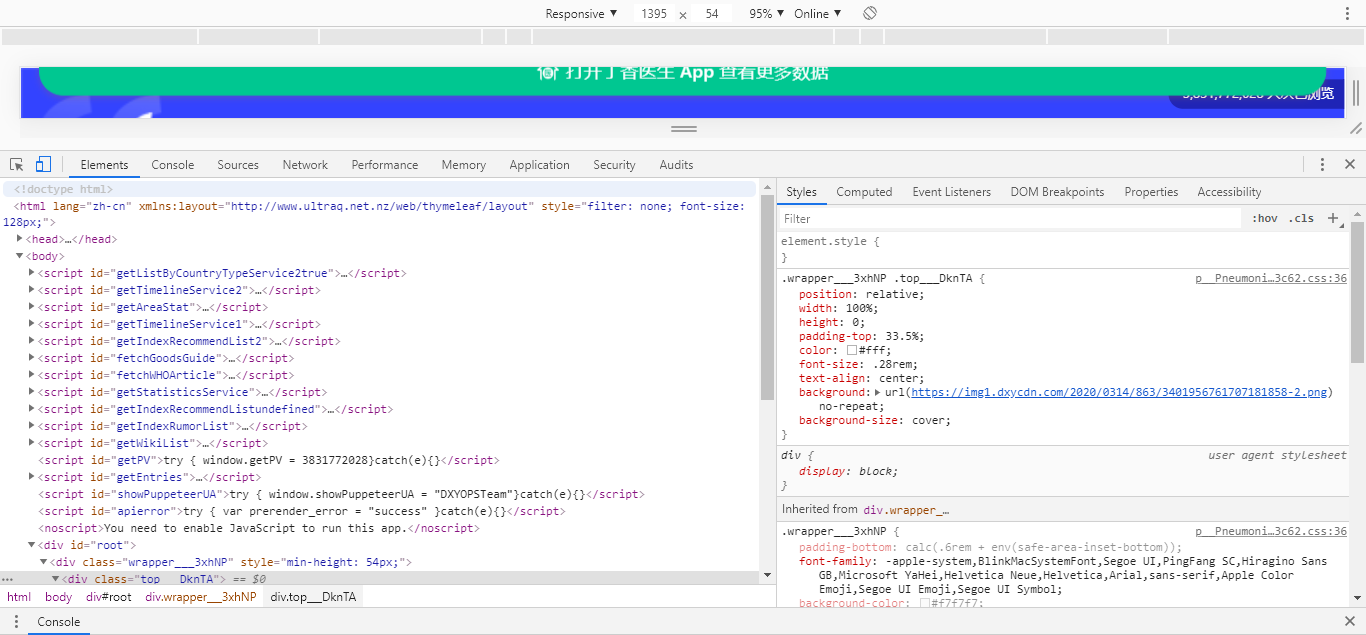

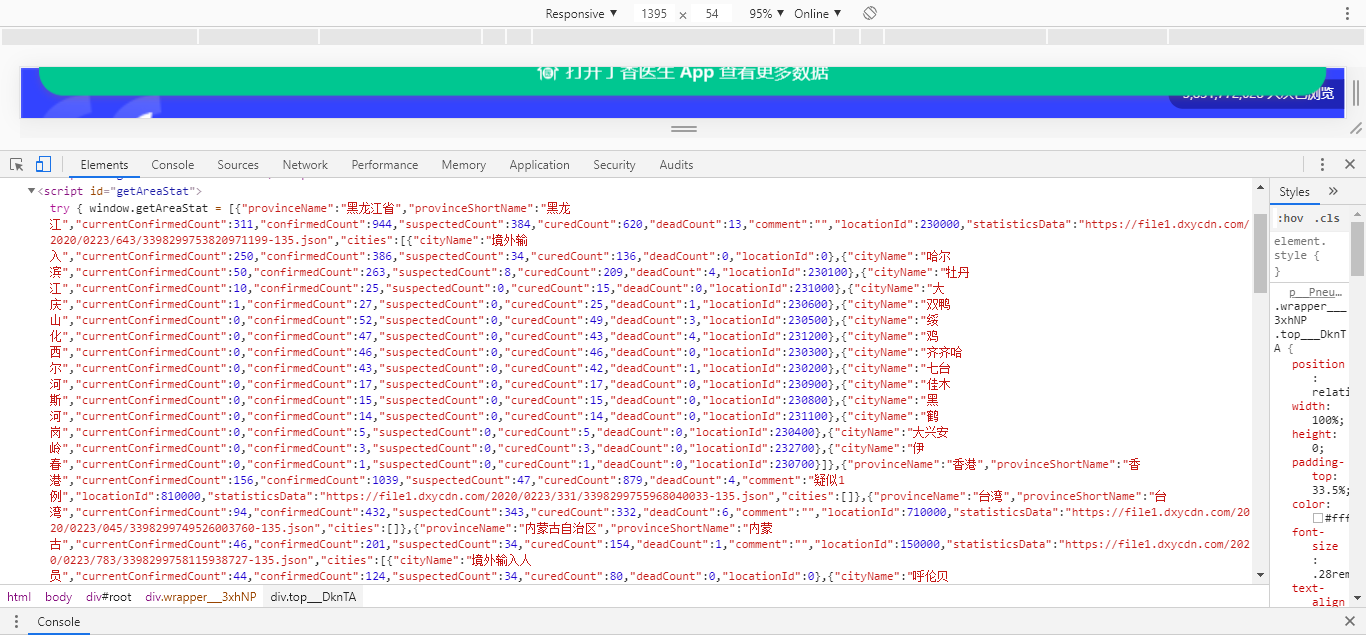

In [37]:
pat0 = re.compile('window.getAreaStat = (.*?)</script>')
pat0

re.compile(r'window.getAreaStat = (.*?)</script>', re.UNICODE)

In [41]:
data_list = pat0.findall(reso.text)

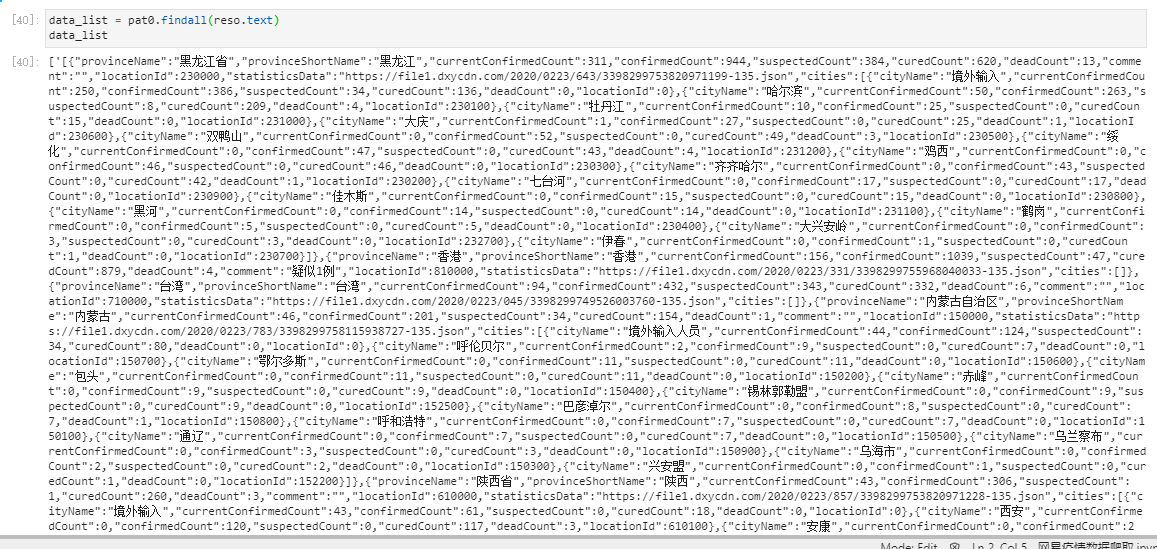

因为data_list打印出来太多了，又无法使用head，所以简单截图展示一下

In [42]:
data1 = data_list[0].replace('}catch(e){}','')

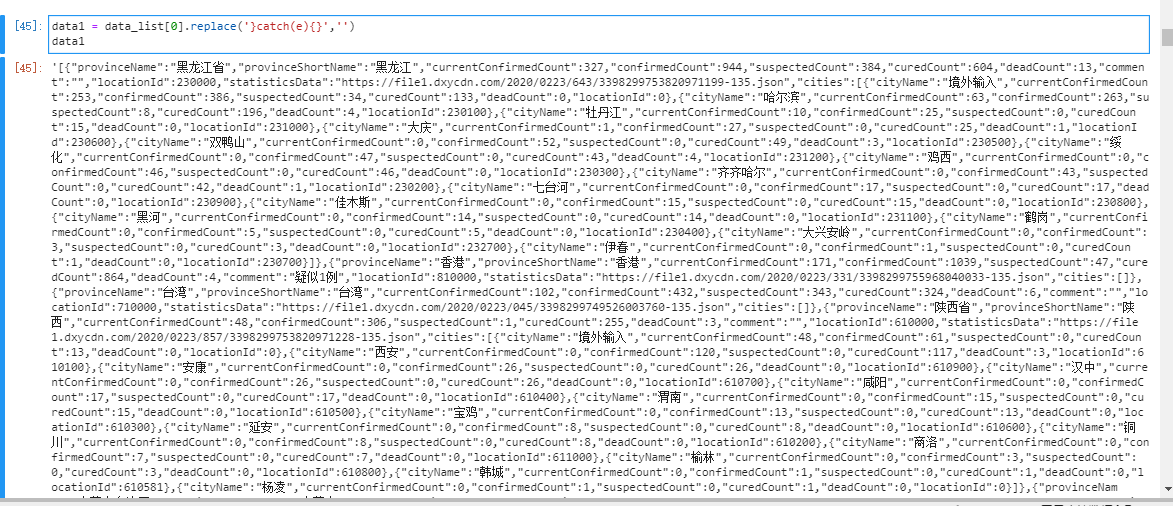

因为data1打印出来太多了，又无法使用head，所以简单截图展示一下

## 列表的字符串转字典数组

In [45]:
data = json.loads(data1)  

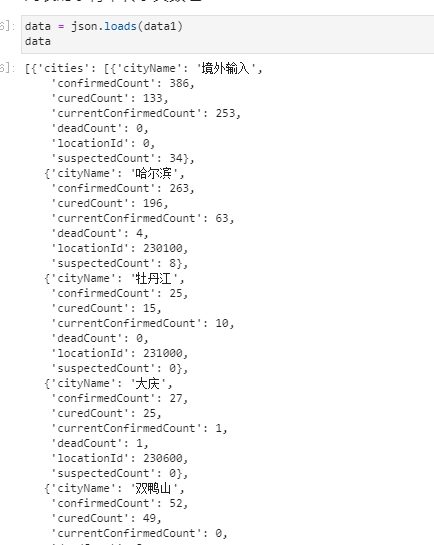

因为data打印出来太多了，又无法使用head，所以简单截图展示一下

## 循环写入新建数据框中

In [46]:
provinceShortNames = []
confirmedCounts = []
curedCounts = []
currentConfirmedCount = []
deadCounts = []

for i in data:
    provinceShortNames.append(i['provinceShortName'])
    confirmedCounts.append(i['confirmedCount'])
    curedCounts.append(i['curedCount'])
    currentConfirmedCount.append(i['currentConfirmedCount'])
    deadCounts.append(i['deadCount'])

df = pd.DataFrame()
df['省份'] = provinceShortNames
df['总确诊数'] = confirmedCounts
df['治愈'] = curedCounts
df['现存确诊数'] = currentConfirmedCount
df['死亡'] = deadCounts

df.head(10)

,省份,总确诊数,治愈,现存确诊数,死亡
0,黑龙江,944,620,311,13
1,香港,1039,879,156,4
2,台湾,432,332,94,6
3,内蒙古,201,154,46,1
4,陕西,306,260,43,3
5,北京,593,551,33,9
6,上海,653,615,31,7
7,山西,198,176,22,0
8,广东,1588,1567,13,8
9,山东,787,772,8,7


## 数据存储

In [47]:
E=df.to_excel('G:/CDO/数据存储和获取/自定义爬虫作业/疫情数据.xlsx',encoding='utf-8')
E

# 绘制 现存确诊数的 玫瑰图

In [49]:
import pyecharts
import pandas as pd
from pyecharts.charts import Pie
from pyecharts import options as opts

给现存确诊数排序

In [50]:
df1=df.sort_values(by='现存确诊数', ascending=False)
df1.head(10)

,省份,总确诊数,治愈,现存确诊数,死亡
0,黑龙江,944,620,311,13
1,香港,1039,879,156,4
2,台湾,432,332,94,6
3,内蒙古,201,154,46,1
4,陕西,306,260,43,3
5,北京,593,551,33,9
6,上海,653,615,31,7
7,山西,198,176,22,0
8,广东,1588,1567,13,8
9,山东,787,772,8,7


封装一个玫瑰图函数

In [51]:
def plot_rose(item_list, data_list, title_string):
    ziped_item_data_list = [list(z) for z in zip(item_list, data_list)]

    rose_diagram = Pie(init_opts=opts.InitOpts(width='650px', height='650px'))
    rose_diagram.add("", ziped_item_data_list, radius=["40%", "130%"], center=["50%", "70%"], rosetype="area")
    rose_diagram.set_global_opts(title_opts=opts.TitleOpts(title=title_string),
                                 legend_opts=opts.LegendOpts(is_show=False),
                                 toolbox_opts=opts.ToolboxOpts()
                                )
    label_opts = opts.LabelOpts(is_show=True, position="inside", font_size=12, formatter="{b}:{c}人")
    rose_diagram.set_series_opts(label_opts=label_opts)
    rose_diagram.render('{}.html'.format(title_string))
    return rose_diagram

索引设置相关数据

In [52]:
item_oversea_list = df1['省份'].values.tolist()
data_oversea_list = df1['现存确诊数'].values.tolist()
title_string = "rose-diagram"

绘图

In [55]:
rose2 = plot_rose(item_oversea_list, data_oversea_list, title_string)
rose2.render_notebook()

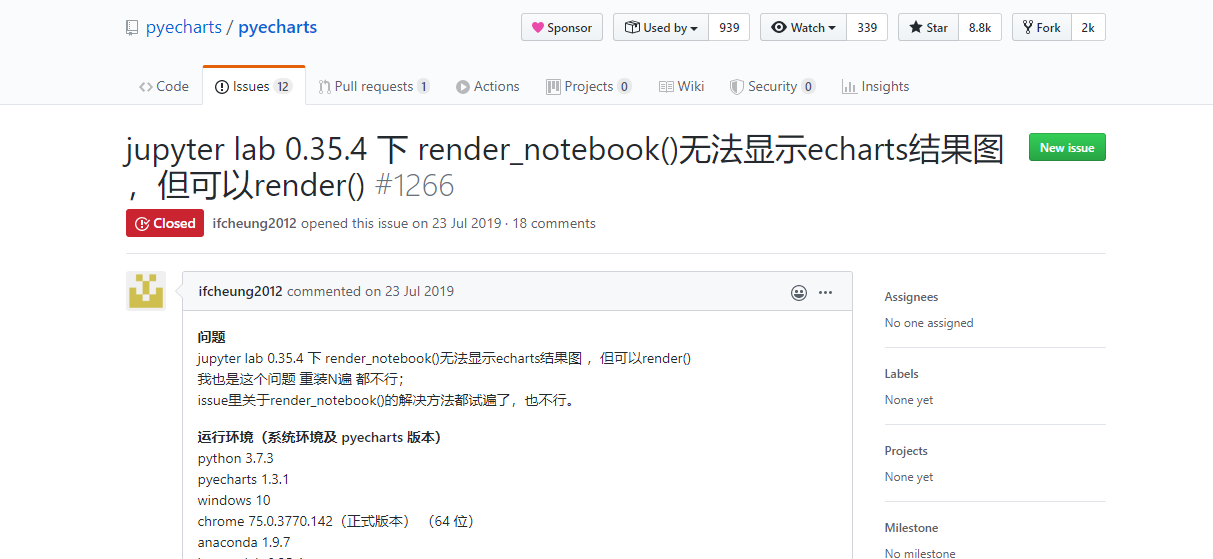

In [56]:
rose2.load_javascript()

# 虽然jupyter lab 不行，但是jupyter notebook 可以， 插一我于4月28日用notebook爬取数据画的截图，将就看看吧

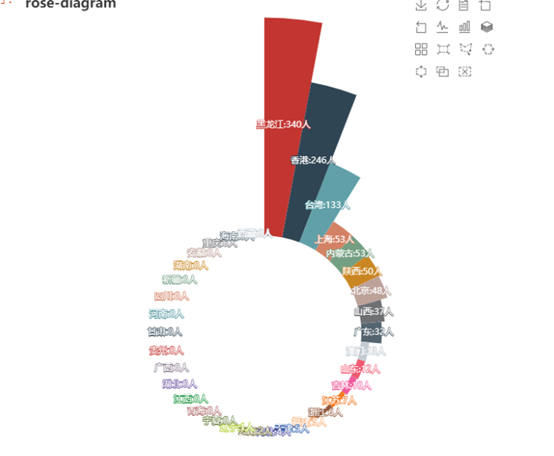

# 疫情数据过于沉闷，接下来我们聊聊好玩的事情

# 豆瓣话题 ： 冠状疫情退去后的第一天你打算做什么？

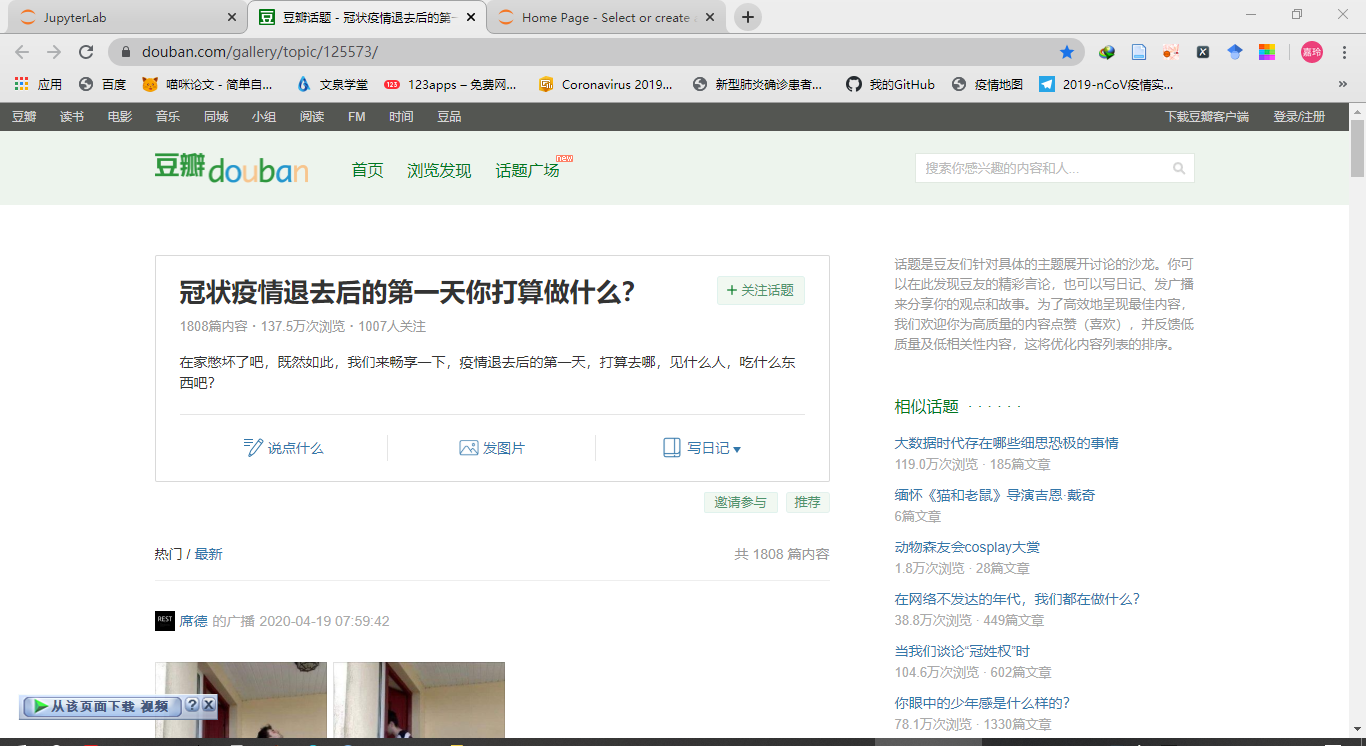

# 爬取豆瓣话题评论

https://www.douban.com/gallery/topic/125573/

解析网页

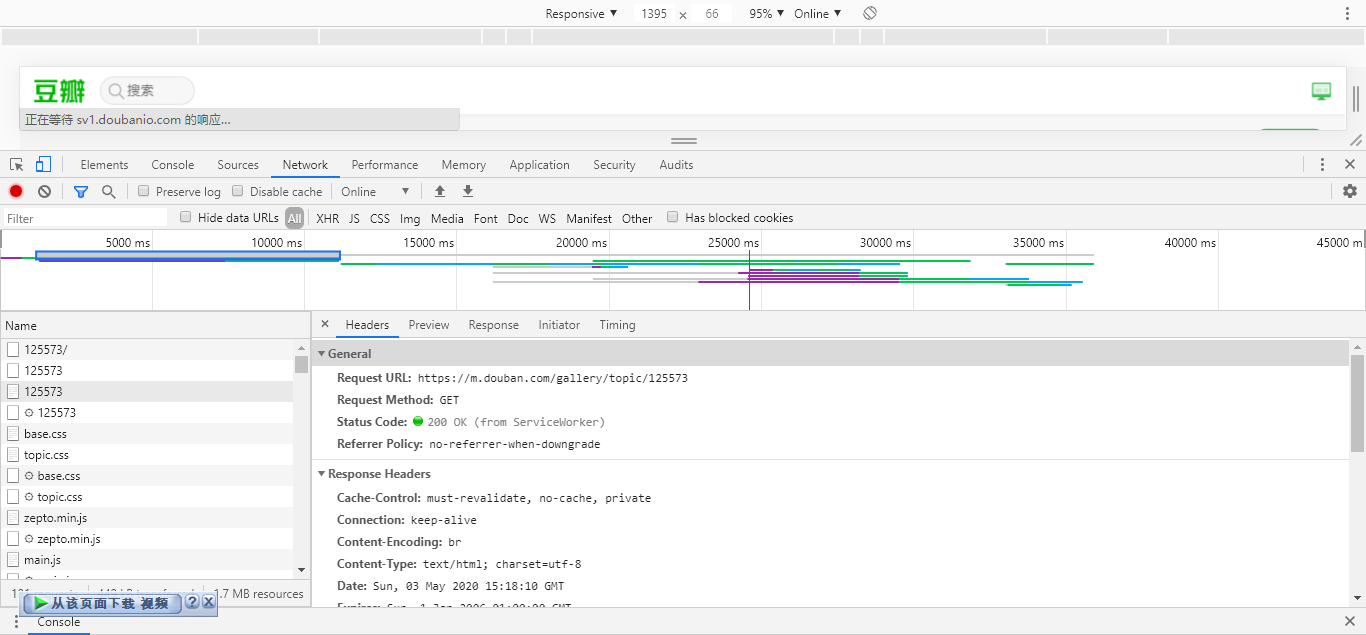

精准获取URL

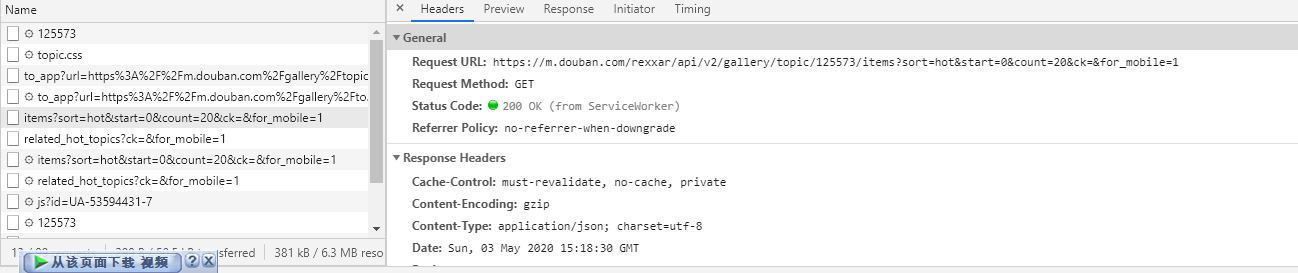

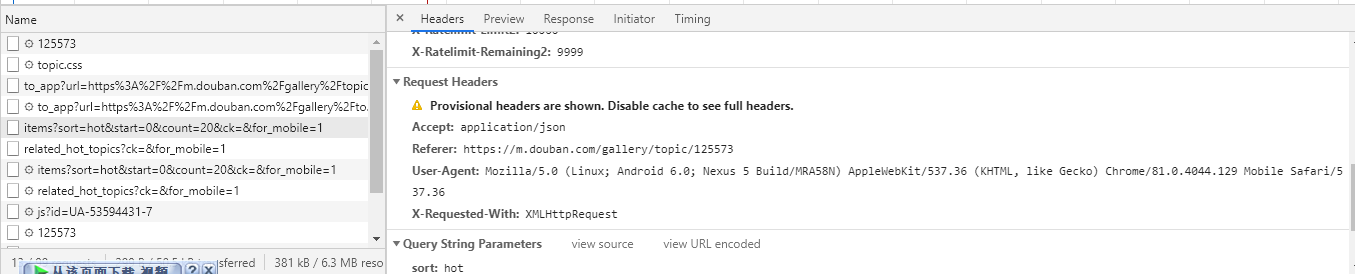

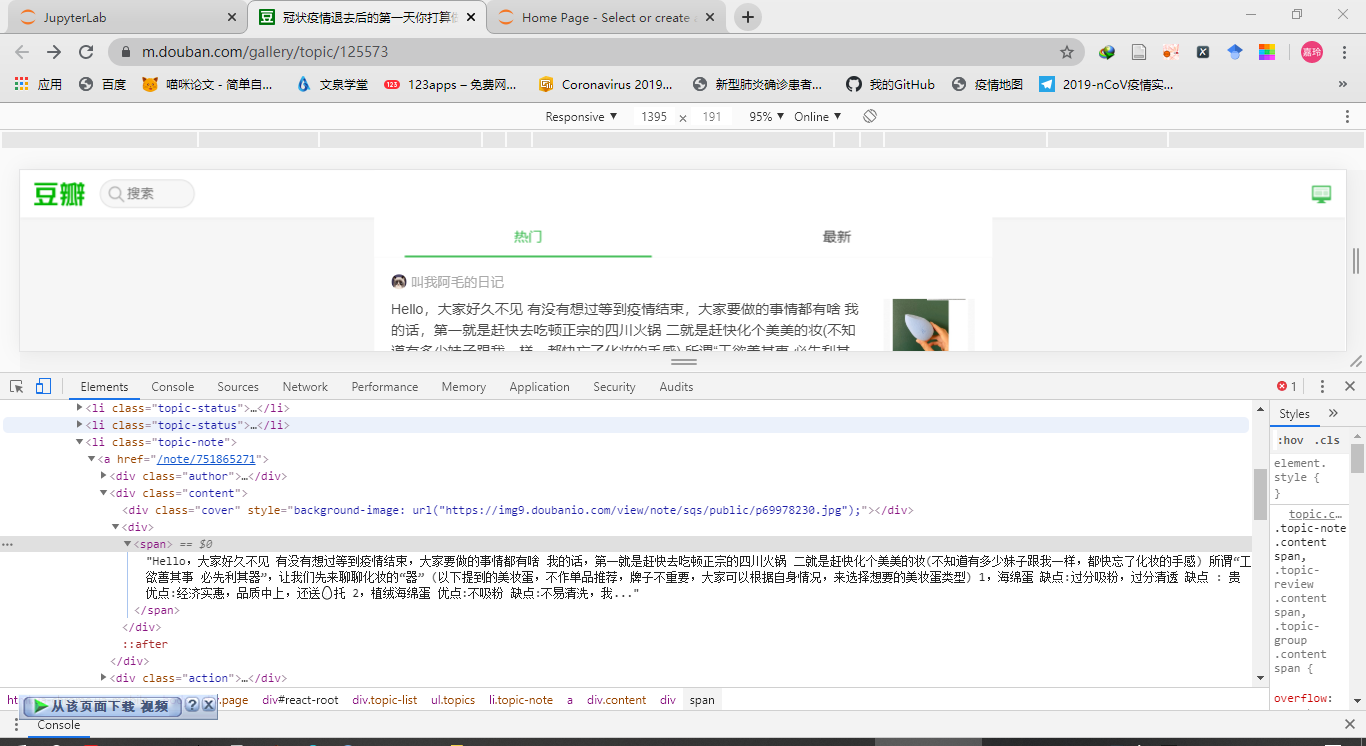

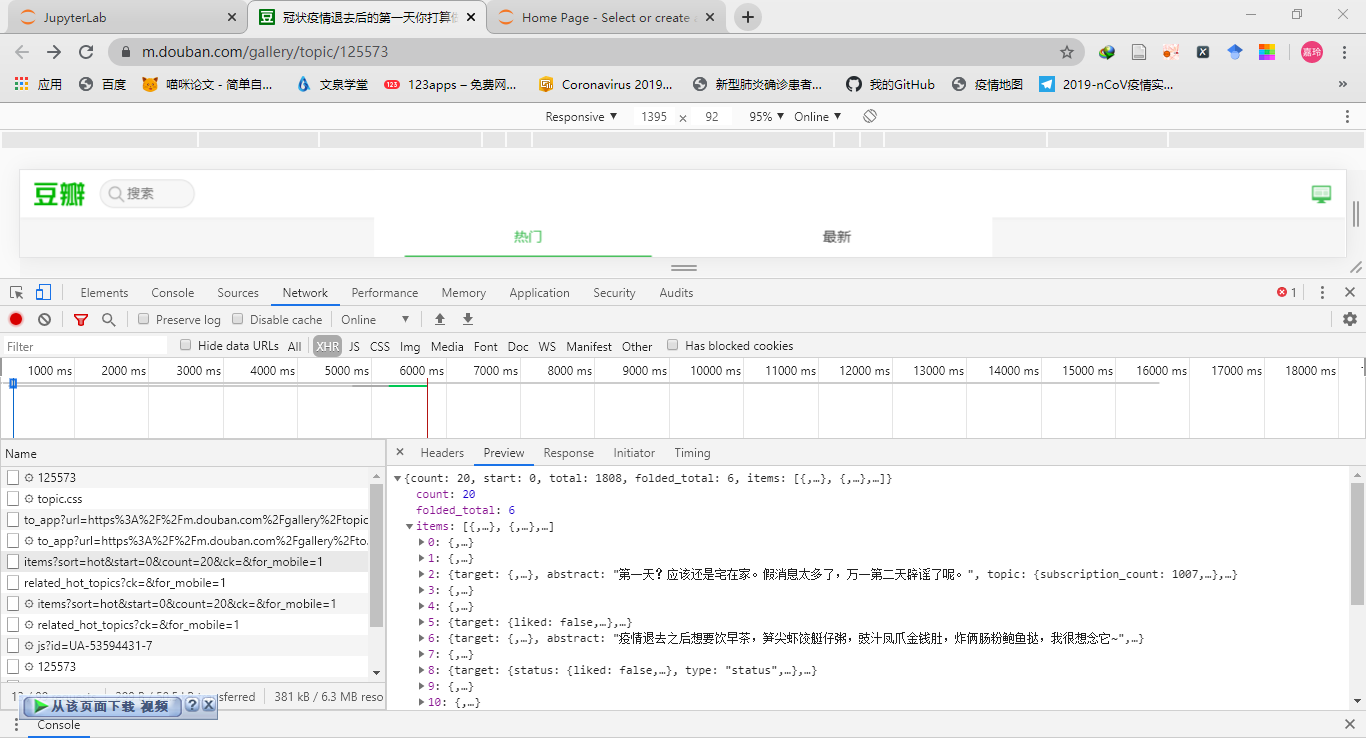

## 我们发现该网页评论数据在 items 节点下，abstract 的内容

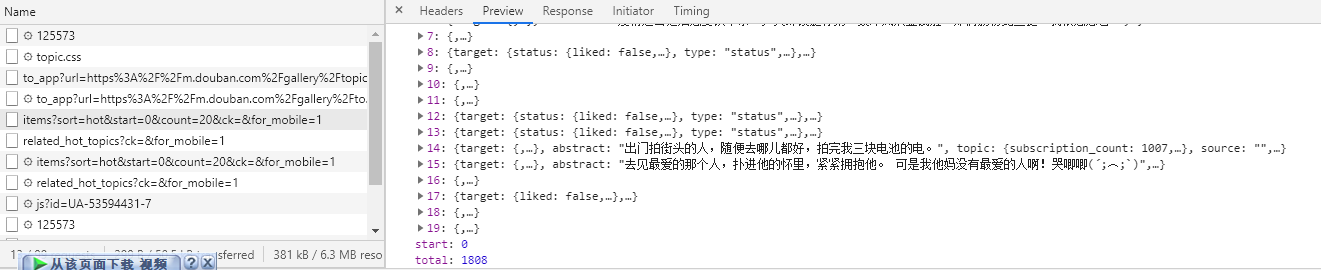

## 我们发现它一共有19页

In [62]:
for i in range(0,200,19):

    url = 'https://m.douban.com/rexxar/api/v2/gallery/topic/125573/items?' \
          'sort=new&start={}&count=20&status_full_text=1&guest_only=0&ck=null'.format(i)
    headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/76.0".3809.100 Safari/537.36',
               'Referer': 'https://www.douban.com/gallery/topic/125573/?from=gallery_trend&sort=hot'}

    reponse = requests.get(url, headers=headers)
    html = reponse.json()

    for j in range(19):
        abs = html['items'][j]['abstract']
        with open("G:/CDO/数据存储和获取/自定义爬虫作业/want_after.txt", "a", encoding='utf-8') as f:
            f.write(abs)
            print(abs)

全球经济一体化, 覆巢之下焉有完卵？疫情只有在世界范围内退去才是真的退去。希望那时能休假, 周游世界, 去每个曾生活过的地方。致谢过往生命里重要的人, 曾帮助过自己的人, 喜欢过的人, 想睡而没睡的人。生命如此脆弱, 这次是Covid-19, 下一次呢？明天的明天会不会有C...
来一个灵魂拷问: 大家的肚子还好吗😾
想去南京扬州。 但又一次错过了烟花三月。 今年两人定的主题词就是“玩儿”，赶在被高压催孕的时节前面，疯狂享受自由的乐趣，疯狂玩耍，听起来很像秋后蚂蚱。去扬州这件事其实已经计划了两年，却总因自己之前“还有很多机会”的愚蠢想法作祟，所以去的意志不够坚决或是买不到票这样的客观原...
我想吃好吃的，见相见的人，去做SPA，或者泡泡温泉……想做的太多了
少扯淡，就想知道啥时候是结束。
想出门吃火锅，想去爬山，想去河边散步，想去公园遛弯
第一天不知道，但是接下来都是考试吧
今天是在京隔离的第六天，下午看到新闻说北京降到二级了，然后在想是不是可以不用隔离了，接着便出来了新闻，可以解除隔离了。赶紧和居委会打电话核实，居委会表示他们没有收到通知，需要等通知。 过了两个小时居委会打来电话说我解除隔离了！！！ 顿时有种刑满释放的感觉，有种自由的感觉！！...
吃了整整三个月，马上出来爬长城 准备整理好思绪和身体 开始迎接工作
最近疫情缓和，生活各方面都松绑了。我的解绑生活好像比别人慢半拍，上周才终于见到了朋友。 不知道大家在疫情后做的第一件事是什么？逛街了吗？赏樱了吗？还是溜达完一圈又钻回了屋里？ 看新闻说，很多夫妻受不了24小时无缝衔接的相处，解禁前就预约离婚了。不过也有很多人，充分享受这段相互陪伴的时光，把手挽得更紧了。 如果疫情助推了一场关系的走向，也是好事。危机会把人带到哪里，并不重要，重要的是，人总会在危机中触发一些思考。 不由地想到9年前的日本311大地震。日本...
我只关心什么时候可以摘口罩😷
然而疫情退去并不是一个开关。没有什么第一天。 今天我生日，28岁。有一段时间了，每逢周末都会头疼，工作日不会，大概是闲的。种种迹象看来，我确实是属于事业心较强的，工作会让我feel better. 为了份看起来前景不错的工作跑来了北京，但又实在对这个北方巨兽提不起好感。好在...
去大城市打工还花呗(🐶 出国打工还借呗(🐶
跳舞！这学期的swing dance课随着

IndexError: list index out of range

# 请教大家一个问题，这里报错怎么搞？   虽然不影响获取数据，但是有点难受，大家帮帮孩子吧